### Decision Tree Model Tuning for 2016 - 2020 Data (exports)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import modelinghelper as helper

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from adspy_shared_utilities import plot_feature_importances
#from adspy_shared_utilities import plot_decision_tree

import joblib
import os
from datetime import datetime

# supress future warnings
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
#set up random seed
rng = 42

# set up folder to save results
output_path = 'export_run8_TargetEncoding_gridsearchCV'
dataset = 'export'

if not os.path.exists(output_path):
    os.makedirs(output_path)
else:
    print("Folder already exists")

# file name
prefix = f'{output_path}/{dataset}'

In [3]:
# read in data
p = '../data/'
input_name = 'cleaned.csv'

df = pd.read_csv(f'{p}{input_name}')

In [4]:
df['ship_date_mm'] = df['ship_date_mm'].astype(str)

In [5]:
df.describe()

,control_number,qty,value,qty_new,ship_date_yyyy
count,1.890132e+06,1.890132e+06,1.890132e+06,1.890132e+06,1.890132e+06
mean,2.018142e+09,1.955213e+06,9.658016e+03,1.954949e+06,2.017558e+03
std,1.263350e+06,2.644078e+08,9.355053e+05,2.644078e+08,1.279415e+00
min,2.014539e+09,-1.000000e+00,0.000000e+00,-1.000000e+00,2.016000e+03
25%,2.016978e+09,1.500000e+00,5.100000e+01,1.000000e+00,2.016000e+03
50%,2.017984e+09,9.000000e+00,3.180000e+02,8.000000e+00,2.017000e+03
75%,2.019505e+09,9.300000e+01,2.104000e+03,8.600000e+01,2.019000e+03
max,2.020755e+09,9.990708e+10,1.242236e+09,9.990708e+10,2.020000e+03


In [26]:
non_feature_cols = ['control_number', 'disp_date', 'i_e', 'ship_date', 
                    'cartons', 'qty', 'unit', 'specific_generic_name',
                    'genus', 'species', 'wildlf_cat', 
                    'disp_date_yyyy', 'disp_date_mm', 'disp_ship_date']

target = ['act', 'dp_cd']

feature_cols = ['species_code', 'wildlf_desc', 'wildlf_cat',
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 
                 'value', 'ship_date_mm']

export_df = helper.df_filtering(df, i_e = 'E', f_cols = feature_cols)
# import: 590505 rows × 11 columns
# export: 299340 rows × 11 columns

#### Modeling Pipeline

In [7]:
X_train, X_test, y_train, y_test = helper.data_split(export_df)

#### Decision Tree

In [8]:
clf = DecisionTreeClassifier(random_state=rng)
dt_params={
    'clf__class_weight':[None,
                         'balanced', 
                         #{0:100, 1:1}, 
                         {0:50, 1:1}],
    'clf__max_depth': [2,3,4,5,6,7,8,9,10, None]
}

%time dt_pipe = helper.gridsearch_pipeline(X_train, y_train, clf, dt_params) 
dt_pipe

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END clf__class_weight=None, clf__max_depth=2;, score=0.065 total time=   1.8s
[CV 2/5] END clf__class_weight=None, clf__max_depth=2;, score=0.091 total time=   1.8s
[CV 3/5] END clf__class_weight=None, clf__max_depth=2;, score=0.104 total time=   1.8s
[CV 4/5] END clf__class_weight=None, clf__max_depth=2;, score=0.067 total time=   1.8s
[CV 5/5] END clf__class_weight=None, clf__max_depth=2;, score=0.067 total time=   1.8s
[CV 1/5] END clf__class_weight=None, clf__max_depth=3;, score=0.210 total time=   1.9s
[CV 2/5] END clf__class_weight=None, clf__max_depth=3;, score=0.234 total time=   1.8s
[CV 3/5] END clf__class_weight=None, clf__max_depth=3;, score=0.203 total time=   1.8s
[CV 4/5] END clf__class_weight=None, clf__max_depth=3;, score=0.264 total time=   1.8s
[CV 5/5] END clf__class_weight=None, clf__max_depth=3;, score=0.207 total time=   1.8s
[CV 1/5] END clf__class_weight=None, clf__max_depth=4;, score=0.231 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('targetEncoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['species_code',
                                                                          'wildlf_desc',
                                                                          'wildlf_cat',
                                                                          'ctry_org',
                                                                          'ctry_ie',
                                                                          'purp',
                                                                          'src',
                                                                          'trans_mode',
                                                                          'pt_cd',
                                                                          'ship_date_mm'])])),
                                       ('standardScaler', StandardScaler()),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'clf__class_weight': [None, 'balanced', {0: 50, 1: 1}],
                         'clf__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None]},
             scoring='recall', verbose=3)

In [9]:
joblib.dump(dt_pipe, f'{prefix}_dt_pipe.joblib')

['export_run8_TargetEncoding_gridsearchCV/export_dt_pipe.joblib']

#### Random Forest

In [10]:
clf = RandomForestClassifier(random_state=rng)
rf_params={
    'clf__n_estimators':[4,6,8,10, 20, 30, 50, 100],
    'clf__max_depth': [None, 3, 4, 5,7,8,9, 10],
    'clf__class_weight':['balanced', None]
}

%time rf_pipe = helper.gridsearch_pipeline(X_train, y_train, clf, rf_params) 
rf_pipe

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.301 total time=   2.4s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.291 total time=   2.2s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.330 total time=   2.1s
[CV 4/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.326 total time=   2.1s
[CV 5/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=4;, score=0.313 total time=   2.1s
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=6;, score=0.304 total time=   2.3s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=6;, score=0.291 total time=   2.3s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=None, clf__n_estimators=6;, score=0.345 total time=   2.3s
[CV 4/5] END clf_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('targetEncoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['species_code',
                                                                          'wildlf_desc',
                                                                          'wildlf_cat',
                                                                          'ctry_org',
                                                                          'ctry_ie',
                                                                          'purp',
                                                                          'src',
                                                                          'trans_mode',
                                                                          'pt_cd',
                                                                          'ship_date_mm'])])),
                                       ('standardScaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__class_weight': ['balanced', None],
                         'clf__max_depth': [None, 3, 4, 5, 7, 8, 9, 10],
                         'clf__n_estimators': [4, 6, 8, 10, 20, 30, 50, 100]},
             scoring='recall', verbose=3)

In [11]:
joblib.dump(rf_pipe, f'{prefix}_rf_pipe.joblib')

['export_run8_TargetEncoding_gridsearchCV/export_rf_pipe.joblib']

#### Model Evaluation

Decision Tree (best model)
 [[  508   135]
 [14869 59323]]


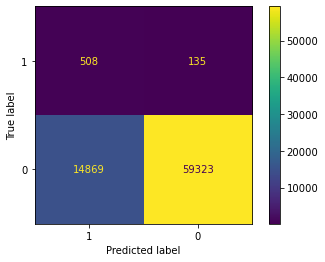

In [21]:
outputs = True
dt_predicted = dt_pipe.predict(X_test)
confusion = confusion_matrix(y_test, dt_predicted, labels = [1,0])
if outputs:
    print('Decision Tree (best model)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()
    
    

Random Forest (best model)
 [[  482   161]
 [ 8067 66125]]


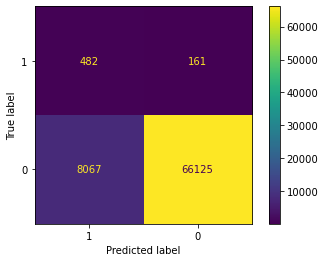

In [22]:
outputs = True
rf_predicted = rf_pipe.predict(X_test)
confusion = confusion_matrix(y_test, rf_predicted, labels = [1,0])
if outputs:
    print('Random Forest (best model)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()

In [28]:
import joblib
dt_path = 'export_run8_TargetEncoding_gridsearchCV/export_dt_pipe.joblib'
rf_path = 'export_run8_TargetEncoding_gridsearchCV/export_rf_pipe.joblib'
dt_pipe = joblib.load(dt_path)
rf_pipe = joblib.load(rf_path)

feature_cols = ['species_code', 'wildlf_desc', #'wildlf_cat',
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 
                 'value', 'ship_date_mm']
outputs = True

In [27]:
feature_cols

['species_code',
 'wildlf_desc',
 'wildlf_cat',
 'ctry_org',
 'ctry_ie',
 'purp',
 'src',
 'trans_mode',
 'pt_cd',
 'value',
 'ship_date_mm']

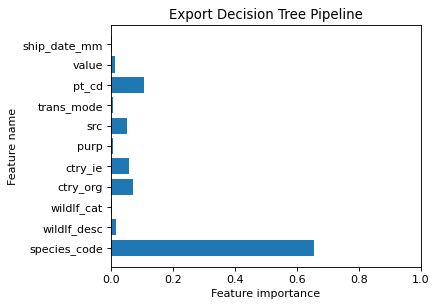

Feature importances: [0.00467588 0.01396435 0.10578004 0.00594284 0.05395879 0.00782518
 0.0599586  0.07100489 0.00304132 0.01765366 0.65619446]


In [33]:
plt.figure(figsize=(5,4), dpi=80)
plot_feature_importances(dt_pipe.best_estimator_.named_steps['clf'], feature_cols)
plt.title('Export Decision Tree Pipeline')
plt.xlim(0, 1)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(dt_pipe.best_estimator_.named_steps['clf'].feature_importances_[::-1]))

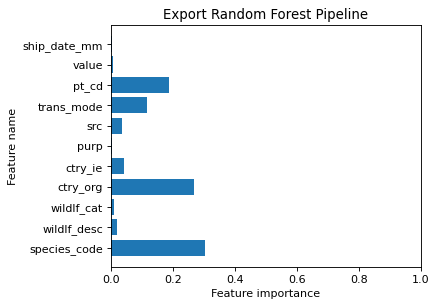

Feature importances: [0.0028886  0.00647118 0.18674778 0.11613145 0.03692334 0.0049524
 0.04221217 0.2678949  0.01016668 0.02019468 0.30541682]


In [34]:
plt.figure(figsize=(5,4), dpi=80)
plot_feature_importances(rf_pipe.best_estimator_.named_steps['clf'], feature_cols)
plt.title('Export Random Forest Pipeline')
plt.xlim(0, 1)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(rf_pipe.best_estimator_.named_steps['clf'].feature_importances_[::-1]))

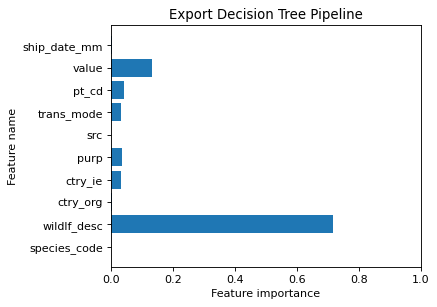

Feature importances: [0.00321966 0.13187795 0.04302748 0.03336364 0.         0.03524511
 0.03202669 0.00409178 0.71714769 0.        ]


In [23]:
from adspy_shared_utilities import plot_feature_importances
from adspy_shared_utilities import plot_decision_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4), dpi=80)
plot_feature_importances(dt_pipe.best_estimator_.named_steps['clf'], feature_cols)
plt.title('Export Decision Tree without wildlife_cat Pipeline')
plt.xlim(0, 1)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(dt_pipe.best_estimator_.named_steps['clf'].feature_importances_[::-1]))

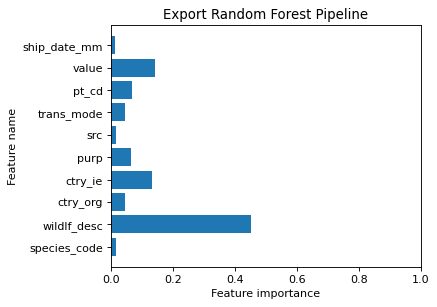

Feature importances: [0.01541045 0.14192583 0.06733032 0.04672271 0.01562113 0.06563515
 0.13185839 0.04729252 0.4523843  0.0158192 ]


In [24]:
plt.figure(figsize=(5,4), dpi=80)
plot_feature_importances(rf_pipe.best_estimator_.named_steps['clf'], feature_cols)
plt.title('Export Random Forest Pipeline')
plt.xlim(0, 1)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(rf_pipe.best_estimator_.named_steps['clf'].feature_importances_[::-1]))